# Dependencies and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error as mse

from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor, RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, ExtraTreesRegressor

from joblib import dump, load, Parallel, delayed

In [2]:
metadata = pd.read_csv('../data/metadata.csv')
sub_format = pd.read_csv('../data/submission_format.csv')
train_labels = pd.read_csv('../data/train_labels.csv')

In [80]:
metadata.date = pd.to_datetime(metadata.date)
metadata['year'] = metadata.date.dt.year
metadata['month'] = metadata.date.dt.month
metadata['week'] = metadata.date.dt.isocalendar().week

seasons = {
    1: 1,
    2: 1,
    3: 2,
    4: 2,
    5: 2,
    6: 3,
    7: 3,
    8: 3,
    9: 4,
    10: 4,
    11: 4,
    12: 1
}

reg_sev_map = {
    'midwest': 2,
    'northeast': 2,
    'south' : 2,
    'west' : 4
}

reg_map = {
    'south' : 0,
    'northeast' : 1,
    'west' : 2,
    'midwest' : 3
}

metadata['season'] = metadata.month.map(seasons)

region = pd.concat((train_labels, sub_format[['region', 'uid']]), axis=0)

all_data = pd.merge(metadata, region, on='uid', how='left')
data = all_data.copy(deep=True)
data.sort_values(by='date', inplace=True)
data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
4387,evep,44.847993,-93.476318,2013-01-04,train,2013,1,1,1,midwest,1.0,115.0
13644,paev,44.822478,-93.367962,2013-01-04,train,2013,1,1,1,midwest,1.0,1884.0
5566,gdxr,44.877646,-93.557842,2013-01-04,train,2013,1,1,1,midwest,1.0,1416.0
6144,guny,44.878889,-93.490833,2013-01-04,train,2013,1,1,1,midwest,1.0,558.0
5317,fwbt,44.850500,-93.515700,2013-01-04,train,2013,1,1,1,midwest,1.0,476.0
...,...,...,...,...,...,...,...,...,...,...,...,...
12443,nsoi,36.736800,-121.734000,2021-12-29,test,2021,12,52,1,west,NaN,NaN
17559,thki,36.725400,-121.730000,2021-12-29,test,2021,12,52,1,west,NaN,NaN
17452,teuu,36.772300,-121.788000,2021-12-29,test,2021,12,52,1,west,NaN,NaN
14254,prfi,36.751800,-121.742000,2021-12-29,test,2021,12,52,1,west,NaN,NaN


# Utils

In [4]:

def analyize_matches(y_true, y_pred, plot=False):
    print("Exact matches: ", sum(y_true == y_pred) / len(y_true))
    print("Missed by 1: ", sum(abs(y_true - y_pred) == 1) / len(y_true))
    print("Missed by 2: ", sum(abs(y_true - y_pred) == 2) / len(y_true))
    print("Missed by 3: ", sum(abs(y_true - y_pred) == 3) / len(y_true))
    print("Missed by 4: ", sum(abs(y_true - y_pred) == 4) / len(y_true))
    
    stupid_vals = []
    for i in range(1, 6):
        stupid_vals.append(
            ((sum([1 for x, y in zip(y_true, y_pred) if x == i and y == i])/len(y_true))*100, (sum(y_true == i)/len(y_true))*100)
            )

    print()
    for i in range(5):
        print(f"Severity {i+1} : accuracy: {np.round(stupid_vals[i][0], 3)} % - prevalence: {np.round(stupid_vals[i][1], 3)} %")
    
    try:
        print()
        print("Classification report:")
        print(classification_report(y_true, y_pred))
    except Exception as e:
        print(e)
        print("Classification report failed")
        
    if plot:
        print()
        sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Reds')


def rmse(y_true, y_pred):
    return mse(y_true, y_pred, squared=False)

def get_data_by_date( date=None, data=None):
    return data[data.date == date]


def get_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).km

# Knn fts

In [5]:
def knn(row=None, train_data=None, k=1):
    """
    row : pd.Series (row from val_data)
    train_data : pd.DataFrame (all_data)
    k : int number of nearest neighbours to consider
    
    algo:
    1. Get past month data collected till the current row
    2. Get the k nearest neighbours (geodesic dist using lat, lng) from the above data
    3. Get the mean of the severity from the above rows
    4. Return the mean of the nearest neighbours severity

    """
    
    if row is None:
        print('Row None bruv!')
        return None
    
    uid = row.uid
    date = row.date
    region = row.region
    past_date = date - pd.Timedelta(days=30)
    
    past_month_data = train_data[(train_data.date < date) & (train_data.date >= past_date)]
    past_month_data.sort_values(by='date', inplace=True)
    
    # if no past data, return the mean of the region
    if len(past_month_data) == 0:
        return reg_sev_map[region]
        
    dist_matrix =pd.DataFrame(columns=['uid', 'dist'])       # 0th col for uid, 1st col for dist
    for i, past_row in enumerate(past_month_data.itertuples()):
        dist_matrix.loc[i, 'uid'] = past_row.uid
        dist_matrix.loc[i, 'dist'] = get_distance(row.latitude, row.longitude, past_row.latitude, past_row.longitude)   # returns geodesic dist in km

    # get mean of top k nearest neighbours
    n_uids = dist_matrix.sort_values(by='dist').head(k).uid.values
    nn_severity = train_data[train_data.uid.isin(n_uids)].severity.mean()
    

    if nn_severity not in range(1, 6):
        return reg_sev_map[region]

    return np.round(nn_severity)

In [6]:
def knn_wrapper(data, k=5):
    preds = []
    for row in tqdm(data.itertuples(), total=len(data)):
        severity = knn(row, train_data=data, k=15)
        preds.append(severity)
    return preds

In [7]:
# def knn_wrapper(data, k=5):
#     sev_list = Parallel(n_jobs=-1, backend='threading')([delayed(knn)(row, train_data=data, k=k) for row in data.itertuples()])
#     return sev_list

In [8]:
data = data.sort_values(by='date')
data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
4387,evep,44.847993,-93.476318,2013-01-04,train,2013,1,1,1,midwest,1.0,115.0
13644,paev,44.822478,-93.367962,2013-01-04,train,2013,1,1,1,midwest,1.0,1884.0
5566,gdxr,44.877646,-93.557842,2013-01-04,train,2013,1,1,1,midwest,1.0,1416.0
6144,guny,44.878889,-93.490833,2013-01-04,train,2013,1,1,1,midwest,1.0,558.0
5317,fwbt,44.850500,-93.515700,2013-01-04,train,2013,1,1,1,midwest,1.0,476.0
...,...,...,...,...,...,...,...,...,...,...,...,...
12443,nsoi,36.736800,-121.734000,2021-12-29,test,2021,12,52,1,west,NaN,NaN
17559,thki,36.725400,-121.730000,2021-12-29,test,2021,12,52,1,west,NaN,NaN
17452,teuu,36.772300,-121.788000,2021-12-29,test,2021,12,52,1,west,NaN,NaN
14254,prfi,36.751800,-121.742000,2021-12-29,test,2021,12,52,1,west,NaN,NaN


In [9]:
# %%time

# tar_data = data
# knn15_preds = []
# for row in tqdm(tar_data.itertuples(), total=len(tar_data)):
#     severity = knn(row, train_data=tar_data, k=15)
#     knn15_preds.append(severity)

# Add fts

In [10]:
data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
4387,evep,44.847993,-93.476318,2013-01-04,train,2013,1,1,1,midwest,1.0,115.0
13644,paev,44.822478,-93.367962,2013-01-04,train,2013,1,1,1,midwest,1.0,1884.0
5566,gdxr,44.877646,-93.557842,2013-01-04,train,2013,1,1,1,midwest,1.0,1416.0
6144,guny,44.878889,-93.490833,2013-01-04,train,2013,1,1,1,midwest,1.0,558.0
5317,fwbt,44.850500,-93.515700,2013-01-04,train,2013,1,1,1,midwest,1.0,476.0
...,...,...,...,...,...,...,...,...,...,...,...,...
12443,nsoi,36.736800,-121.734000,2021-12-29,test,2021,12,52,1,west,NaN,NaN
17559,thki,36.725400,-121.730000,2021-12-29,test,2021,12,52,1,west,NaN,NaN
17452,teuu,36.772300,-121.788000,2021-12-29,test,2021,12,52,1,west,NaN,NaN
14254,prfi,36.751800,-121.742000,2021-12-29,test,2021,12,52,1,west,NaN,NaN


In [162]:
data.split.value_counts(normalize=True)

train    0.723801
test     0.276199
Name: split, dtype: float64

In [163]:
data['mysplit'] = data.split
train_idx, val_idx = train_test_split(data[data.split == 'train'].index, test_size=0.276199, random_state=42)
org_severity = data.severity
train_severity = data.loc[train_idx, 'severity']
val_severity = data.loc[val_idx, 'severity']

data.loc[val_idx, 'severity'] = np.nan
data.loc[val_idx, 'mysplit'] = 'val'

In [164]:
train_data_ = data[data.mysplit == 'train']
train_data_.severity.value_counts(normalize=True)

1.0    0.441367
4.0    0.207402
2.0    0.190719
3.0    0.157029
5.0    0.003482
Name: severity, dtype: float64

In [165]:
train_data_.shape, val_idx.shape

((12348, 26), (4712,))

In [166]:
val_severity

18933    1.0
4341     1.0
16865    1.0
18889    4.0
985      3.0
        ... 
8715     1.0
9096     1.0
6757     1.0
23493    1.0
7053     2.0
Name: severity, Length: 4712, dtype: float64

In [167]:
val_severity.value_counts(normalize=True)

1.0    0.434423
4.0    0.209253
2.0    0.187606
3.0    0.165535
5.0    0.003183
Name: severity, dtype: float64

## Grpby fts

In [86]:
grp_by_r = data.groupby(['region']).severity.mean()
grp_by_r = grp_by_r.map(np.round)
print(grp_by_r.isna().sum())  
grp_by_r.fillna(grp_by_r.groupby('region').transform('mean'), inplace=True)
print(grp_by_r.isna().sum())

grp_by_r_preds = data[['region']].apply(lambda x: grp_by_r[x.region], axis=1)
analyize_matches(train_data_.severity.sort_index(), grp_by_r_preds.loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), grp_by_r_preds.loc[train_data_.index].sort_index())

0
0
Exact matches:  0.3682590855803048
Missed by 1:  0.5929806565064478
Missed by 2:  0.026743845252051583
Missed by 3:  0.01201641266119578
Missed by 4:  0.0

Severity 1 : accuracy: 0.0 % - prevalence: 44.065 %
Severity 2 : accuracy: 18.171 % - prevalence: 18.765 %
Severity 3 : accuracy: 0.0 % - prevalence: 16.068 %
Severity 4 : accuracy: 18.655 % - prevalence: 20.736 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.366 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00      6014
         2.0       0.23      0.97      0.38      2561
         3.0       0.00      0.00      0.00      2193
         4.0       0.85      0.90      0.87      2830
         5.0       0.00      0.00      0.00        50

    accuracy                           0.37     13648
   macro avg       0.22      0.37      0.25     13648
weighted avg       0.22      0.37      0.25     13648



0.898945911312475

In [87]:
grp_by_r = data.groupby(['month']).severity.mean()
grp_by_r = grp_by_r.map(np.round)
print(grp_by_r.isna().sum())  
grp_by_r.fillna(grp_by_r.groupby('month').transform('mean'), inplace=True)
print(grp_by_r.isna().sum())

grp_by_r_preds = data[['month']].apply(lambda x: grp_by_r[x.month], axis=1)
analyize_matches(train_data_.severity.sort_index(), grp_by_r_preds.loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), grp_by_r_preds.loc[train_data_.index].sort_index())

0
0
Exact matches:  0.1863276670574443
Missed by 1:  0.6060228604923799
Missed by 2:  0.20398593200468934
Missed by 3:  0.003663540445486518
Missed by 4:  0.0

Severity 1 : accuracy: 0.0 % - prevalence: 44.065 %
Severity 2 : accuracy: 18.362 % - prevalence: 18.765 %
Severity 3 : accuracy: 0.271 % - prevalence: 16.068 %
Severity 4 : accuracy: 0.0 % - prevalence: 20.736 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.366 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00      6014
         2.0       0.19      0.98      0.32      2561
         3.0       0.06      0.02      0.03      2193
         4.0       0.00      0.00      0.00      2830
         5.0       0.00      0.00      0.00        50

    accuracy                           0.19     13648
   macro avg       0.05      0.20      0.07     13648
weighted avg       0.05      0.19      0.06     13648



1.2062082956606275

In [88]:
grp_by_r = data.groupby(['season']).severity.mean()
grp_by_r = grp_by_r.map(np.round)
print(grp_by_r.isna().sum())  
grp_by_r.fillna(grp_by_r.groupby('season').transform('mean'), inplace=True)
print(grp_by_r.isna().sum())

grp_by_r_preds = data[['season']].apply(lambda x: grp_by_r[x.season], axis=1)
analyize_matches(train_data_.severity.sort_index(), grp_by_r_preds.loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), grp_by_r_preds.loc[train_data_.index].sort_index())

0
0
Exact matches:  0.18764654161781946
Missed by 1:  0.6013335287221571
Missed by 2:  0.20735638921453692
Missed by 3:  0.003663540445486518
Missed by 4:  0.0

Severity 1 : accuracy: 0.0 % - prevalence: 44.065 %
Severity 2 : accuracy: 18.765 % - prevalence: 18.765 %
Severity 3 : accuracy: 0.0 % - prevalence: 16.068 %
Severity 4 : accuracy: 0.0 % - prevalence: 20.736 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.366 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00      6014
         2.0       0.19      1.00      0.32      2561
         3.0       0.00      0.00      0.00      2193
         4.0       0.00      0.00      0.00      2830
         5.0       0.00      0.00      0.00        50

    accuracy                           0.19     13648
   macro avg       0.04      0.20      0.06     13648
weighted avg       0.04      0.19      0.06     13648



1.2098474902191942

In [89]:
grp_by_r = data.groupby(['year']).severity.mean()
grp_by_r = grp_by_r.map(np.round)
print(grp_by_r.isna().sum())  
grp_by_r.fillna(grp_by_r.groupby('year').transform('mean'), inplace=True)
print(grp_by_r.isna().sum())

grp_by_r_preds = data[['year']].apply(lambda x: grp_by_r[x.year], axis=1)
analyize_matches(train_data_.severity.sort_index(), grp_by_r_preds.loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), grp_by_r_preds.loc[train_data_.index].sort_index())

0
0
Exact matches:  0.18764654161781946
Missed by 1:  0.6013335287221571
Missed by 2:  0.20735638921453692
Missed by 3:  0.003663540445486518
Missed by 4:  0.0

Severity 1 : accuracy: 0.0 % - prevalence: 44.065 %
Severity 2 : accuracy: 18.765 % - prevalence: 18.765 %
Severity 3 : accuracy: 0.0 % - prevalence: 16.068 %
Severity 4 : accuracy: 0.0 % - prevalence: 20.736 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.366 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00      6014
         2.0       0.19      1.00      0.32      2561
         3.0       0.00      0.00      0.00      2193
         4.0       0.00      0.00      0.00      2830
         5.0       0.00      0.00      0.00        50

    accuracy                           0.19     13648
   macro avg       0.04      0.20      0.06     13648
weighted avg       0.04      0.19      0.06     13648



1.2098474902191942

In [90]:
grp_by_w = data.groupby(['week']).severity.mean()
grp_by_w = grp_by_w.map(np.round)
print(grp_by_w.isna().sum())  
grp_by_w.fillna(grp_by_w.groupby('week').transform('mean'), inplace=True)
print(grp_by_w.isna().sum())

grp_by_w_preds = data[['week']].apply(lambda x: grp_by_w[x.week], axis=1)
analyize_matches(train_data_.severity.sort_index(), grp_by_w_preds.loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), grp_by_w_preds.loc[train_data_.index].sort_index())

1
1
Exact matches:  0.19966295427901523
Missed by 1:  0.6051436107854631
Missed by 2:  0.1901377491207503
Missed by 3:  0.005055685814771395
Missed by 4:  0.0

Severity 1 : accuracy: 0.975 % - prevalence: 44.065 %
Severity 2 : accuracy: 17.541 % - prevalence: 18.765 %
Severity 3 : accuracy: 0.85 % - prevalence: 16.068 %
Severity 4 : accuracy: 0.601 % - prevalence: 20.736 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.366 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.83      0.02      0.04      6014
         2.0       0.20      0.93      0.33      2561
         3.0       0.08      0.05      0.06      2193
         4.0       0.83      0.03      0.06      2830
         5.0       0.00      0.00      0.00        50

    accuracy                           0.20     13648
   macro avg       0.39      0.21      0.10     13648
weighted avg       0.59      0.20      0.10     13648



1.1879376160394142

In [17]:
exp_grp_by_rm = data.groupby(['region', 'month']).severity.expanding(1).mean()
exp_grp_by_rm = exp_grp_by_rm.map(np.round)
print(exp_grp_by_rm.isna().sum())  
exp_grp_by_rm.droplevel(0).droplevel(0)
exp_grp_by_rm.fillna(exp_grp_by_rm.groupby('region').transform('mean'), inplace=True)
print(exp_grp_by_rm.isna().sum())  
analyize_matches(train_data_.severity.sort_index(), exp_grp_by_rm.droplevel(0).droplevel(0).loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), np.round(exp_grp_by_rm.droplevel(0).droplevel(0).loc[train_data_.index].sort_index()))

75
0
Exact matches:  0.5003516998827667
Missed by 1:  0.44196951934349354
Missed by 2:  0.04753810082063306
Missed by 3:  0.009788980070339976
Missed by 4:  0.00035169988276670573

Severity 1 : accuracy: 19.871 % - prevalence: 43.945 %
Severity 2 : accuracy: 12.749 % - prevalence: 18.986 %
Severity 3 : accuracy: 0.51 % - prevalence: 15.938 %
Severity 4 : accuracy: 16.905 % - prevalence: 20.791 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.34 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.72      0.45      0.56      7497
         2.0       0.26      0.67      0.37      3239
         3.0       0.17      0.03      0.05      2719
         4.0       0.86      0.81      0.84      3547
         5.0       0.00      0.00      0.00        58

    accuracy                           0.50     17060
   macro avg       0.40      0.39      0.36     17060
weighted avg       0.57      0.50      0.50     17060



0.8519682748690546

In [91]:
grp_by_rm = data.groupby(['region', 'month']).severity.mean()
grp_by_rm = grp_by_rm.map(np.round)
print(grp_by_rm.isna().sum())  
grp_by_rm.fillna(grp_by_rm.groupby('region').transform('mean'), inplace=True)
print(grp_by_rm.isna().sum())

grp_by_rm_preds = data[['region', 'month']].apply(lambda x: grp_by_rm[x.region, x.month], axis=1)
analyize_matches(train_data_.severity.sort_index(), grp_by_rm_preds.loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), grp_by_rm_preds.loc[train_data_.index].sort_index())

1
0
Exact matches:  0.4547919109026964
Missed by 1:  0.49479777256740914
Missed by 2:  0.0412514654161782
Missed by 3:  0.008939038686987104
Missed by 4:  0.0002198124267291911

Severity 1 : accuracy: 14.405 % - prevalence: 44.065 %
Severity 2 : accuracy: 14.522 % - prevalence: 18.765 %
Severity 3 : accuracy: 0.278 % - prevalence: 16.068 %
Severity 4 : accuracy: 16.273 % - prevalence: 20.736 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.366 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.74      0.33      0.45      6014
         2.0       0.25      0.77      0.38      2561
         3.0       0.09      0.02      0.03      2193
         4.0       0.86      0.78      0.82      2830
         5.0       0.00      0.00      0.00        50

    accuracy                           0.45     13648
   macro avg       0.39      0.38      0.34     13648
weighted avg       0.57      0.45      0.45     13648



0.8624221595266862

In [92]:
exp_grp_by_rmy = data.groupby(['region', 'month', 'year']).severity.expanding(1).mean()
exp_grp_by_rmy = exp_grp_by_rmy.map(np.round)
print(exp_grp_by_rmy.isna().sum())  
exp_grp_by_rmy.droplevel(0).droplevel(0)
exp_grp_by_rmy.fillna(exp_grp_by_rmy.groupby('region').transform('mean'), inplace=True)
print(exp_grp_by_rmy.isna().sum())  
analyize_matches(train_data_.severity.sort_index(), exp_grp_by_rmy.droplevel(0).droplevel(0).droplevel(0).loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), np.round(exp_grp_by_rmy.droplevel(0).droplevel(0).droplevel(0).loc[train_data_.index].sort_index()))

754
0
Exact matches:  0.536928487690504
Missed by 1:  0.41705744431418523
Missed by 2:  0.04139800703399765
Missed by 3:  0.004469519343493552
Missed by 4:  0.00014654161781946072

Severity 1 : accuracy: 20.831 % - prevalence: 44.065 %
Severity 2 : accuracy: 13.145 % - prevalence: 18.765 %
Severity 3 : accuracy: 3.026 % - prevalence: 16.068 %
Severity 4 : accuracy: 16.632 % - prevalence: 20.736 %
Severity 5 : accuracy: 0.059 % - prevalence: 0.366 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.78      0.47      0.59      6014
         2.0       0.28      0.70      0.40      2561
         3.0       0.40      0.19      0.26      2193
         4.0       0.90      0.80      0.85      2830
         5.0       0.89      0.16      0.27        50

    accuracy                           0.54     13648
   macro avg       0.65      0.46      0.47     13648
weighted avg       0.65      0.54      0.55     13648



0.7907084244060697

In [93]:
grp_by_rmy = data.groupby(['region', 'month', 'year']).severity.mean()
grp_by_rmy = grp_by_rmy.map(np.round)
print(grp_by_rmy.isna().sum())  
grp_by_rmy.fillna(grp_by_rmy.groupby('region').transform('mean'), inplace=True)
print(grp_by_rmy.isna().sum())

grp_by_rmy_preds = data[['region', 'month', 'year']].apply(lambda x: grp_by_rmy[x.region, x.month, x.year], axis=1)
analyize_matches(train_data_.severity.sort_index(), grp_by_rmy_preds.loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), grp_by_rmy_preds.loc[train_data_.index].sort_index())

21
0
Exact matches:  0.508426143024619
Missed by 1:  0.4423358733880422
Missed by 2:  0.04447538100820633
Missed by 3:  0.004616060961313013
Missed by 4:  0.00014654161781946072

Severity 1 : accuracy: 19.124 % - prevalence: 44.065 %
Severity 2 : accuracy: 12.859 % - prevalence: 18.765 %
Severity 3 : accuracy: 2.66 % - prevalence: 16.068 %
Severity 4 : accuracy: 16.2 % - prevalence: 20.736 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.366 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.76      0.43      0.55      6014
         2.0       0.27      0.69      0.38      2561
         3.0       0.32      0.17      0.22      2193
         4.0       0.90      0.78      0.84      2830
         5.0       0.00      0.00      0.00        50

    accuracy                           0.51     13648
   macro avg       0.45      0.41      0.40     13648
weighted avg       0.62      0.51      0.52     13648



0.8149396370025181

In [94]:
grp_by_rsy = data.groupby(['region', 'season', 'year']).severity.mean()
grp_by_rsy = grp_by_rsy.map(np.round)
print(grp_by_rsy.isna().sum())  
grp_by_rsy.fillna(grp_by_rsy.groupby('region').transform('mean'), inplace=True)
print(grp_by_rsy.isna().sum())

grp_by_rsy_preds = data[['region', 'season', 'year']].apply(lambda x: grp_by_rsy[x.region, x.season, x.year], axis=1)
analyize_matches(train_data_.severity.sort_index(), grp_by_rsy_preds.loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), grp_by_rsy_preds.loc[train_data_.index].sort_index())

5
0
Exact matches:  0.49142731535756157
Missed by 1:  0.4561107854630715
Missed by 2:  0.045427901524032824
Missed by 3:  0.006740914419695193
Missed by 4:  0.00029308323563892143

Severity 1 : accuracy: 17.863 % - prevalence: 44.065 %
Severity 2 : accuracy: 12.8 % - prevalence: 18.765 %
Severity 3 : accuracy: 1.92 % - prevalence: 16.068 %
Severity 4 : accuracy: 16.559 % - prevalence: 20.736 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.366 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.73      0.41      0.52      6014
         2.0       0.25      0.68      0.37      2561
         3.0       0.29      0.12      0.17      2193
         4.0       0.89      0.80      0.84      2830
         5.0       0.00      0.00      0.00        50

    accuracy                           0.49     13648
   macro avg       0.43      0.40      0.38     13648
weighted avg       0.60      0.49      0.50     13648



0.8385582586240996

In [95]:
grp_by_rms = data.groupby(['region', 'month', 'season']).severity.mean()
grp_by_rms = grp_by_rms.map(np.round)
print(grp_by_rms.isna().sum())  
grp_by_rms.fillna(grp_by_rms.groupby('region').transform('mean'), inplace=True)
print(grp_by_rms.isna().sum())

grp_by_rms_preds = data[['region', 'month', 'season']].apply(lambda x: grp_by_rms[x.region, x.month, x.season], axis=1)
analyize_matches(train_data_.severity.sort_index(), grp_by_rms_preds.loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), grp_by_rms_preds.loc[train_data_.index].sort_index())

1
0
Exact matches:  0.4547919109026964
Missed by 1:  0.49479777256740914
Missed by 2:  0.0412514654161782
Missed by 3:  0.008939038686987104
Missed by 4:  0.0002198124267291911

Severity 1 : accuracy: 14.405 % - prevalence: 44.065 %
Severity 2 : accuracy: 14.522 % - prevalence: 18.765 %
Severity 3 : accuracy: 0.278 % - prevalence: 16.068 %
Severity 4 : accuracy: 16.273 % - prevalence: 20.736 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.366 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.74      0.33      0.45      6014
         2.0       0.25      0.77      0.38      2561
         3.0       0.09      0.02      0.03      2193
         4.0       0.86      0.78      0.82      2830
         5.0       0.00      0.00      0.00        50

    accuracy                           0.45     13648
   macro avg       0.39      0.38      0.34     13648
weighted avg       0.57      0.45      0.45     13648



0.8624221595266862

In [96]:
grp_by_smr = data.groupby(['season', 'month', 'region']).severity.mean()
grp_by_smr = grp_by_smr.map(np.round)
print(grp_by_smr.isna().sum())  
grp_by_smr.fillna(grp_by_smr.groupby('season').transform('mean'), inplace=True)
print(grp_by_smr.isna().sum())

grp_by_smr_preds = data[['season', 'month', 'region']].apply(lambda x: grp_by_smr[x.season, x.month, x.region], axis=1)
analyize_matches(train_data_.severity.sort_index(), grp_by_smr_preds.loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), grp_by_smr_preds.loc[train_data_.index].sort_index())

1
0
Exact matches:  0.4547919109026964
Missed by 1:  0.49479777256740914
Missed by 2:  0.0412514654161782
Missed by 3:  0.008939038686987104
Missed by 4:  0.0002198124267291911

Severity 1 : accuracy: 14.405 % - prevalence: 44.065 %
Severity 2 : accuracy: 14.522 % - prevalence: 18.765 %
Severity 3 : accuracy: 0.278 % - prevalence: 16.068 %
Severity 4 : accuracy: 16.273 % - prevalence: 20.736 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.366 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.74      0.33      0.45      6014
         2.0       0.25      0.77      0.38      2561
         3.0       0.09      0.02      0.03      2193
         4.0       0.86      0.78      0.82      2830
         5.0       0.00      0.00      0.00        50

    accuracy                           0.45     13648
   macro avg       0.39      0.38      0.34     13648
weighted avg       0.57      0.45      0.45     13648



0.8624221595266862

In [97]:
grp_by_msy = data.groupby(['month', 'season', 'year']).severity.mean()
grp_by_msy = grp_by_msy.map(np.round)
print(grp_by_msy.isna().sum())  
grp_by_msy.fillna(grp_by_msy.groupby('month').transform('mean'), inplace=True)
print(grp_by_msy.isna().sum())

grp_by_msy_preds = data[['month', 'season', 'year']].apply(lambda x: grp_by_msy[x.month, x.season, x.year], axis=1)
analyize_matches(train_data_.severity.sort_index(), grp_by_msy_preds.loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), grp_by_msy_preds.loc[train_data_.index].sort_index())

0
0
Exact matches:  0.1930685814771395
Missed by 1:  0.6101260257913247
Missed by 2:  0.19343493552168817
Missed by 3:  0.0033704572098475966
Missed by 4:  0.0

Severity 1 : accuracy: 0.0 % - prevalence: 44.065 %
Severity 2 : accuracy: 18.127 % - prevalence: 18.765 %
Severity 3 : accuracy: 0.63 % - prevalence: 16.068 %
Severity 4 : accuracy: 0.55 % - prevalence: 20.736 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.366 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00      6014
         2.0       0.20      0.97      0.33      2561
         3.0       0.09      0.04      0.06      2193
         4.0       0.89      0.03      0.05      2830
         5.0       0.00      0.00      0.00        50

    accuracy                           0.19     13648
   macro avg       0.24      0.21      0.09     13648
weighted avg       0.24      0.19      0.08     13648



1.189201363422825

## Rolling fts

In [98]:
# rolling severity average
rolling_severity = data.severity.rolling(3).mean()
rolling_severity = rolling_severity.map(np.round)
rolling_severity.fillna(rolling_severity.mean(), inplace=True)
print(rolling_severity.isna().sum())
analyize_matches(train_data_.severity.sort_index(), rolling_severity.loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), rolling_severity.loc[train_data_.index].sort_index())

0
Exact matches:  0.24875439624853457
Missed by 1:  0.18061254396248536
Missed by 2:  0.021541617819460727
Missed by 3:  7.327080890973036e-05
Missed by 4:  0.0

Severity 1 : accuracy: 12.954 % - prevalence: 44.065 %
Severity 2 : accuracy: 5.026 % - prevalence: 18.765 %
Severity 3 : accuracy: 2.176 % - prevalence: 16.068 %
Severity 4 : accuracy: 4.719 % - prevalence: 20.736 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.366 %

Classification report:
Classification metrics can't handle a mix of multiclass and continuous targets
Classification report failed


1.0525902715797977

In [99]:
# rolling severity average grouped by region

rolling_severity_by_r = data.groupby('region').severity.rolling(3).mean()
rolling_severity_by_r = rolling_severity_by_r.map(np.round)
rolling_severity_by_r.fillna(rolling_severity_by_r.groupby('region').transform('mean'), inplace=True)
rolling_severity_by_r = rolling_severity_by_r.map(np.round)
print(rolling_severity_by_r.isna().sum())
analyize_matches(train_data_.severity.sort_index(), rolling_severity_by_r.droplevel(0).loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), rolling_severity_by_r.droplevel(0).loc[train_data_.index].sort_index())

0
Exact matches:  0.5173651817116061
Missed by 1:  0.45142145369284875
Missed by 2:  0.023739742086752638
Missed by 3:  0.007473622508792497
Missed by 4:  0.0

Severity 1 : accuracy: 16.757 % - prevalence: 44.065 %
Severity 2 : accuracy: 14.508 % - prevalence: 18.765 %
Severity 3 : accuracy: 2.271 % - prevalence: 16.068 %
Severity 4 : accuracy: 18.193 % - prevalence: 20.736 %
Severity 5 : accuracy: 0.007 % - prevalence: 0.366 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.85      0.38      0.52      6014
         2.0       0.26      0.77      0.39      2561
         3.0       0.53      0.14      0.22      2193
         4.0       0.87      0.88      0.88      2830
         5.0       0.33      0.02      0.04        50

    accuracy                           0.52     13648
   macro avg       0.57      0.44      0.41     13648
weighted avg       0.69      0.52      0.52     13648



0.7833537033926576

In [100]:
# rolling severity average grouped by region

rolling_severity_by_r5 = data.groupby('region').severity.rolling(5).mean()
rolling_severity_by_r5 = rolling_severity_by_r5.map(np.round)
rolling_severity_by_r5.fillna(rolling_severity_by_r5.groupby('region').transform('mean'), inplace=True)
rolling_severity_by_r5 = rolling_severity_by_r5.map(np.round)
print(rolling_severity_by_r5.isna().sum())
analyize_matches(train_data_.severity.sort_index(), rolling_severity_by_r5.droplevel(0).loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), rolling_severity_by_r5.droplevel(0).loc[train_data_.index].sort_index())

0
Exact matches:  0.4425556858147714
Missed by 1:  0.5174384525205158
Missed by 2:  0.03048065650644783
Missed by 3:  0.009525205158264946
Missed by 4:  0.0

Severity 1 : accuracy: 9.012 % - prevalence: 44.065 %
Severity 2 : accuracy: 16.281 % - prevalence: 18.765 %
Severity 3 : accuracy: 0.615 % - prevalence: 16.068 %
Severity 4 : accuracy: 18.347 % - prevalence: 20.736 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.366 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.81      0.20      0.33      6014
         2.0       0.25      0.87      0.38      2561
         3.0       0.43      0.04      0.07      2193
         4.0       0.86      0.88      0.87      2830
         5.0       0.00      0.00      0.00        50

    accuracy                           0.44     13648
   macro avg       0.47      0.40      0.33     13648
weighted avg       0.65      0.44      0.41     13648



0.8515209480515976

In [101]:
rolling_severity_by_r7 = data.groupby('region').severity.rolling(7).mean()
rolling_severity_by_r7 = rolling_severity_by_r7.map(np.round)
rolling_severity_by_r7.fillna(rolling_severity_by_r7.groupby('region').transform('mean'), inplace=True)
rolling_severity_by_r7 = rolling_severity_by_r7.map(np.round)
print(rolling_severity_by_r7.isna().sum())
analyize_matches(train_data_.severity.sort_index(), rolling_severity_by_r7.droplevel(0).loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), rolling_severity_by_r7.droplevel(0).loc[train_data_.index].sort_index())

0
Exact matches:  0.40716588511137164
Missed by 1:  0.5520955451348183
Missed by 2:  0.029674677608440798
Missed by 3:  0.011063892145369285
Missed by 4:  0.0

Severity 1 : accuracy: 5.041 % - prevalence: 44.065 %
Severity 2 : accuracy: 17.013 % - prevalence: 18.765 %
Severity 3 : accuracy: 0.161 % - prevalence: 16.068 %
Severity 4 : accuracy: 18.501 % - prevalence: 20.736 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.366 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.78      0.11      0.20      6014
         2.0       0.24      0.91      0.38      2561
         3.0       0.30      0.01      0.02      2193
         4.0       0.85      0.89      0.87      2830
         5.0       0.00      0.00      0.00        50

    accuracy                           0.41     13648
   macro avg       0.43      0.38      0.29     13648
weighted avg       0.61      0.41      0.34     13648



0.8777068331036879

In [102]:
rolling_severity_by_r9 = data.groupby('region').severity.rolling(9).mean()
rolling_severity_by_r9 = rolling_severity_by_r9.map(np.round)
rolling_severity_by_r9.fillna(rolling_severity_by_r9.groupby('region').transform('mean'), inplace=True)
rolling_severity_by_r9 = rolling_severity_by_r9.map(np.round)
print(rolling_severity_by_r9.isna().sum())
analyize_matches(train_data_.severity.sort_index(), rolling_severity_by_r9.droplevel(0).loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), rolling_severity_by_r9.droplevel(0).loc[train_data_.index].sort_index())

0
Exact matches:  0.4026963657678781
Missed by 1:  0.5447684642438453
Missed by 2:  0.03846717467760844
Missed by 3:  0.013262016412661197
Missed by 4:  0.000805978898007034

Severity 1 : accuracy: 6.052 % - prevalence: 44.065 %
Severity 2 : accuracy: 15.629 % - prevalence: 18.765 %
Severity 3 : accuracy: 0.044 % - prevalence: 16.068 %
Severity 4 : accuracy: 18.545 % - prevalence: 20.736 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.366 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.58      0.14      0.22      6014
         2.0       0.23      0.83      0.36      2561
         3.0       0.17      0.00      0.01      2193
         4.0       0.85      0.89      0.87      2830
         5.0       0.00      0.00      0.00        50

    accuracy                           0.40     13648
   macro avg       0.37      0.37      0.29     13648
weighted avg       0.50      0.40      0.35     13648



0.9115322117382042

In [103]:

# rolling_severity_by_r = data.groupby('region').severity.rolling(10).mean()
# rolling_severity_by_r = rolling_severity_by_r.map(np.round)
# rolling_severity_by_r.fillna(rolling_severity_by_r.groupby('region').transform('mean'), inplace=True)
# rolling_severity_by_r = rolling_severity_by_r.map(np.round)
# print(rolling_severity_by_r.isna().sum())
# analyize_matches(train_data_.severity.sort_index(), rolling_severity_by_r.droplevel(0).loc[train_data_.index].sort_index())
# rmse(train_data_.severity.sort_index(), rolling_severity_by_r.droplevel(0).loc[train_data_.index].sort_index())

In [104]:

# rolling_severity_by_r = data.groupby('region').severity.rolling(2).mean()
# rolling_severity_by_r = rolling_severity_by_r.map(np.round)
# rolling_severity_by_r.fillna(rolling_severity_by_r.groupby('region').transform('mean'), inplace=True)
# print(rolling_severity_by_r.isna().sum())
# analyize_matches(train_data_.severity.sort_index(), rolling_severity_by_r.droplevel(0).loc[train_data_.index].sort_index())
# rmse(train_data_.severity.sort_index(), rolling_severity_by_r.droplevel(0).loc[train_data_.index].sort_index())

In [105]:
rolling_severity_by_w = data.groupby('week').severity.rolling(3).mean()
rolling_severity_by_w = rolling_severity_by_w.map(np.round)
print(rolling_severity_by_w.isna().sum())
rolling_severity_by_w.fillna(rolling_severity_by_w.groupby('week').transform('mean'), inplace=True)
print(rolling_severity_by_w.isna().sum())
analyize_matches(train_data_.severity.sort_index(), rolling_severity_by_w.droplevel(0).loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), rolling_severity_by_w.droplevel(0).loc[train_data_.index].sort_index())

17411
21
Exact matches:  0.24860785463071514
Missed by 1:  0.1812719812426729
Missed by 2:  0.021688159437280186
Missed by 3:  7.327080890973036e-05
Missed by 4:  0.0

Severity 1 : accuracy: 12.888 % - prevalence: 44.065 %
Severity 2 : accuracy: 5.041 % - prevalence: 18.765 %
Severity 3 : accuracy: 2.169 % - prevalence: 16.068 %
Severity 4 : accuracy: 4.763 % - prevalence: 20.736 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.366 %

Classification report:
Classification metrics can't handle a mix of multiclass and continuous targets
Classification report failed


1.03194945799821

In [106]:
rolling_severity_by_y = data.groupby('year').severity.rolling(3).mean()
rolling_severity_by_y = rolling_severity_by_y.map(np.round)
print(rolling_severity_by_y.isna().sum())
rolling_severity_by_y.fillna(rolling_severity_by_y.groupby('year').transform('mean'), inplace=True)
print(rolling_severity_by_y.isna().sum())
analyize_matches(train_data_.severity.sort_index(), rolling_severity_by_y.droplevel(0).loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), rolling_severity_by_y.droplevel(0).loc[train_data_.index].sort_index())

17416
0
Exact matches:  0.24868112543962487
Missed by 1:  0.18061254396248536
Missed by 2:  0.021541617819460727
Missed by 3:  7.327080890973036e-05
Missed by 4:  0.0

Severity 1 : accuracy: 12.947 % - prevalence: 44.065 %
Severity 2 : accuracy: 5.026 % - prevalence: 18.765 %
Severity 3 : accuracy: 2.176 % - prevalence: 16.068 %
Severity 4 : accuracy: 4.719 % - prevalence: 20.736 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.366 %

Classification report:
Classification metrics can't handle a mix of multiclass and continuous targets
Classification report failed


1.0465985009917607

In [107]:
rolling_severity_by_m = data.groupby('month').severity.rolling(3).mean()
rolling_severity_by_m = rolling_severity_by_m.map(np.round)
print(rolling_severity_by_m.isna().sum())
rolling_severity_by_m.fillna(rolling_severity_by_m.groupby('month').transform('mean'), inplace=True)
print(rolling_severity_by_m.isna().sum())
analyize_matches(train_data_.severity.sort_index(), rolling_severity_by_m.droplevel(0).loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), rolling_severity_by_m.droplevel(0).loc[train_data_.index].sort_index())

17418
0
Exact matches:  0.27088218053927315
Missed by 1:  0.2490474794841735
Missed by 2:  0.036708675263774915
Missed by 3:  0.0005128956623681126
Missed by 4:  0.0

Severity 1 : accuracy: 12.932 % - prevalence: 44.065 %
Severity 2 : accuracy: 7.261 % - prevalence: 18.765 %
Severity 3 : accuracy: 2.169 % - prevalence: 16.068 %
Severity 4 : accuracy: 4.726 % - prevalence: 20.736 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.366 %

Classification report:
Classification metrics can't handle a mix of multiclass and continuous targets
Classification report failed


1.0481357541344294

In [108]:
data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density,mysplit
4387,evep,44.847993,-93.476318,2013-01-04,train,2013,1,1,1,midwest,NaN,115.0,val
13644,paev,44.822478,-93.367962,2013-01-04,train,2013,1,1,1,midwest,1.0,1884.0,train
5566,gdxr,44.877646,-93.557842,2013-01-04,train,2013,1,1,1,midwest,1.0,1416.0,train
6144,guny,44.878889,-93.490833,2013-01-04,train,2013,1,1,1,midwest,NaN,558.0,val
5317,fwbt,44.850500,-93.515700,2013-01-04,train,2013,1,1,1,midwest,1.0,476.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12443,nsoi,36.736800,-121.734000,2021-12-29,test,2021,12,52,1,west,NaN,NaN,test
17559,thki,36.725400,-121.730000,2021-12-29,test,2021,12,52,1,west,NaN,NaN,test
17452,teuu,36.772300,-121.788000,2021-12-29,test,2021,12,52,1,west,NaN,NaN,test
14254,prfi,36.751800,-121.742000,2021-12-29,test,2021,12,52,1,west,NaN,NaN,test


# Xgboost

In [168]:
data = data.sort_values(by='date')
data

,uid,latitude,longitude,date,split,year,month,week,season,region,...,grp_by_rm,grp_by_rsy,grp_by_msy,rolling_severity_by_m,rolling_severity_by_r,rolling_severity_by_r5,rolling_severity_by_r7,rolling_severity_by_w,rolling_severity_by_y,rolling_severity
4387,evep,44.847993,-93.476318,2013-01-04,train,2013,1,1,1,midwest,...,1.0,1.0,3.0,2.367491,2.0,2.0,2.0,2.122449,1.855131,2.03753
13644,paev,44.822478,-93.367962,2013-01-04,train,2013,1,1,1,midwest,...,1.0,1.0,3.0,2.367491,2.0,2.0,2.0,2.122449,1.855131,2.03753
5566,gdxr,44.877646,-93.557842,2013-01-04,train,2013,1,1,1,midwest,...,1.0,1.0,3.0,2.367491,2.0,2.0,2.0,2.122449,1.855131,2.03753
6144,guny,44.878889,-93.490833,2013-01-04,train,2013,1,1,1,midwest,...,1.0,1.0,3.0,2.367491,2.0,2.0,2.0,2.122449,1.855131,2.03753
5317,fwbt,44.850500,-93.515700,2013-01-04,train,2013,1,1,1,midwest,...,1.0,1.0,3.0,2.367491,2.0,2.0,2.0,2.122449,1.855131,2.03753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12443,nsoi,36.736800,-121.734000,2021-12-29,test,2021,12,52,1,west,...,4.0,4.0,2.0,1.782443,4.0,4.0,4.0,4.000000,2.136704,2.03753
17559,thki,36.725400,-121.730000,2021-12-29,test,2021,12,52,1,west,...,4.0,4.0,2.0,1.782443,4.0,4.0,4.0,4.000000,2.136704,2.03753
17452,teuu,36.772300,-121.788000,2021-12-29,test,2021,12,52,1,west,...,4.0,4.0,2.0,1.782443,4.0,4.0,4.0,4.000000,2.136704,2.03753
14254,prfi,36.751800,-121.742000,2021-12-29,test,2021,12,52,1,west,...,4.0,4.0,2.0,1.782443,4.0,4.0,4.0,4.000000,2.136704,2.03753


In [169]:

data = data.sort_index()
data['grp_by_r'] = grp_by_r_preds.sort_index()
data['grp_by_rmy'] = grp_by_rmy_preds.sort_index()
data['grp_by_rms'] = grp_by_rms_preds.sort_index()
data['grp_by_rm'] = grp_by_rm_preds.sort_index()
data['grp_by_rsy'] = grp_by_rsy_preds.sort_index()
data['grp_by_msy'] = grp_by_msy_preds.sort_index()

data

,uid,latitude,longitude,date,split,year,month,week,season,region,...,grp_by_rm,grp_by_rsy,grp_by_msy,rolling_severity_by_m,rolling_severity_by_r,rolling_severity_by_r5,rolling_severity_by_r7,rolling_severity_by_w,rolling_severity_by_y,rolling_severity
0,aabm,39.080319,-86.430867,2018-05-14,train,2018,5,20,2,midwest,...,1.0,1.0,2.0,1.850704,2.0,2.0,2.0,2.277778,1.921779,2.03753
1,aabn,36.559700,-121.510000,2016-08-31,test,2016,8,35,3,west,...,3.0,4.0,2.0,2.000000,4.0,4.0,4.0,1.917526,1.963600,2.03753
2,aacd,35.875083,-78.878434,2020-11-19,train,2020,11,47,4,south,...,2.0,2.0,2.0,1.000000,1.0,2.0,2.0,1.000000,1.000000,1.00000
3,aaee,35.487000,-79.062133,2016-08-24,train,2016,8,34,3,south,...,2.0,2.0,2.0,2.000000,2.0,2.0,2.0,2.133333,1.963600,2.03753
4,aaff,38.049471,-99.827001,2019-07-23,train,2019,7,30,3,midwest,...,2.0,2.0,2.0,2.068316,2.0,2.0,2.0,1.995192,2.200765,2.03753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23565,zzvv,36.708500,-121.749000,2014-12-02,test,2014,12,49,1,west,...,4.0,4.0,3.0,1.782443,4.0,4.0,4.0,2.282353,2.183219,2.03753
23566,zzwo,39.792190,-99.971050,2017-06-19,train,2017,6,25,3,midwest,...,2.0,2.0,2.0,1.925311,2.0,2.0,2.0,2.168182,2.222222,2.03753
23567,zzwq,35.794000,-79.012551,2015-03-24,train,2015,3,13,2,south,...,1.0,1.0,2.0,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.00000
23568,zzyb,35.742000,-79.238600,2016-11-21,train,2016,11,47,4,south,...,2.0,2.0,2.0,2.059233,2.0,2.0,2.0,2.347826,1.963600,2.03753


In [170]:
# rolling_cols = data.columns[data.columns.str.startswith('grp')]
# data = data.drop(columns=rolling_cols)
# assert data.columns.equals(all_data.columns)

In [171]:
data = data.sort_index()
data['rolling_severity_by_m'] = rolling_severity_by_m.droplevel(0).sort_index()
data['rolling_severity_by_r'] = rolling_severity_by_r.droplevel(0).sort_index()
data['rolling_severity_by_r5'] = rolling_severity_by_r5.droplevel(0).sort_index()
data['rolling_severity_by_r7'] = rolling_severity_by_r7.droplevel(0).sort_index()
data['rolling_severity_by_w'] = rolling_severity_by_w.droplevel(0).sort_index()
data['rolling_severity_by_y'] = rolling_severity_by_y.droplevel(0).sort_index()
data['rolling_severity'] = rolling_severity

data

,uid,latitude,longitude,date,split,year,month,week,season,region,...,grp_by_rm,grp_by_rsy,grp_by_msy,rolling_severity_by_m,rolling_severity_by_r,rolling_severity_by_r5,rolling_severity_by_r7,rolling_severity_by_w,rolling_severity_by_y,rolling_severity
0,aabm,39.080319,-86.430867,2018-05-14,train,2018,5,20,2,midwest,...,1.0,1.0,2.0,1.850704,2.0,2.0,2.0,2.277778,1.921779,2.03753
1,aabn,36.559700,-121.510000,2016-08-31,test,2016,8,35,3,west,...,3.0,4.0,2.0,2.000000,4.0,4.0,4.0,1.917526,1.963600,2.03753
2,aacd,35.875083,-78.878434,2020-11-19,train,2020,11,47,4,south,...,2.0,2.0,2.0,1.000000,1.0,2.0,2.0,1.000000,1.000000,1.00000
3,aaee,35.487000,-79.062133,2016-08-24,train,2016,8,34,3,south,...,2.0,2.0,2.0,2.000000,2.0,2.0,2.0,2.133333,1.963600,2.03753
4,aaff,38.049471,-99.827001,2019-07-23,train,2019,7,30,3,midwest,...,2.0,2.0,2.0,2.068316,2.0,2.0,2.0,1.995192,2.200765,2.03753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23565,zzvv,36.708500,-121.749000,2014-12-02,test,2014,12,49,1,west,...,4.0,4.0,3.0,1.782443,4.0,4.0,4.0,2.282353,2.183219,2.03753
23566,zzwo,39.792190,-99.971050,2017-06-19,train,2017,6,25,3,midwest,...,2.0,2.0,2.0,1.925311,2.0,2.0,2.0,2.168182,2.222222,2.03753
23567,zzwq,35.794000,-79.012551,2015-03-24,train,2015,3,13,2,south,...,1.0,1.0,2.0,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.00000
23568,zzyb,35.742000,-79.238600,2016-11-21,train,2016,11,47,4,south,...,2.0,2.0,2.0,2.059233,2.0,2.0,2.0,2.347826,1.963600,2.03753


In [172]:
# train, test = train_test_split(data[data.mysplit == 'train'], test_size=0.05, random_state=42, shuffle=True)
# train.shape, test.shape

In [173]:
train, test = data[data.mysplit == 'train'], data[data.mysplit == 'val']
train.shape, test.shape

((12348, 26), (4712, 26))

In [174]:
train.region = train.region.map(reg_map)
test.region = test.region.map(reg_map)

train.week = train.week.astype('int')
test.week = test.week.astype('int')

In [175]:
drop_cols = ['uid', 'split', 'date', 'severity', 'density', 'latitude', 'longitude', 'mysplit']

X_train = train.drop(drop_cols, axis=1)
y_train = train['severity']

X_val = test.drop(drop_cols, axis=1)
# y_val = test['severity']
y_val = val_severity.sort_index()

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((12348, 18), (12348,), (4712, 18), (4712,))

In [176]:
y_train.value_counts(normalize=True), y_val.value_counts(normalize=True)

(1.0    0.441367
 4.0    0.207402
 2.0    0.190719
 3.0    0.157029
 5.0    0.003482
 Name: severity, dtype: float64,
 1.0    0.434423
 4.0    0.209253
 2.0    0.187606
 3.0    0.165535
 5.0    0.003183
 Name: severity, dtype: float64)

In [177]:
X_val

,year,month,week,season,region,grp_by_r,grp_by_rmy,grp_by_rms,grp_by_rm,grp_by_rsy,grp_by_msy,rolling_severity_by_m,rolling_severity_by_r,rolling_severity_by_r5,rolling_severity_by_r7,rolling_severity_by_w,rolling_severity_by_y,rolling_severity
0,2018,5,20,2,3,2.0,1.0,1.0,1.0,1.0,2.0,1.850704,2.0,2.0,2.0,2.277778,1.921779,2.03753
4,2019,7,30,3,3,2.0,3.0,2.0,2.0,2.0,2.0,2.068316,2.0,2.0,2.0,1.995192,2.200765,2.03753
6,2017,11,46,4,0,2.0,2.0,2.0,2.0,2.0,2.0,1.000000,1.0,2.0,2.0,1.000000,1.000000,1.00000
9,2018,6,26,3,0,2.0,2.0,2.0,2.0,2.0,2.0,2.000000,2.0,1.0,2.0,2.000000,2.000000,2.00000
20,2018,6,24,3,0,2.0,2.0,2.0,2.0,2.0,2.0,1.000000,1.0,1.0,2.0,1.000000,1.000000,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23559,2018,6,26,3,0,2.0,2.0,2.0,2.0,2.0,2.0,1.925311,2.0,2.0,2.0,1.625000,1.921779,2.03753
23562,2018,6,26,3,0,2.0,2.0,2.0,2.0,2.0,2.0,1.925311,2.0,2.0,2.0,1.625000,1.921779,2.03753
23564,2015,8,32,3,0,2.0,2.0,2.0,2.0,2.0,2.0,2.000000,2.0,2.0,2.0,1.850980,1.921693,2.03753
23567,2015,3,13,2,0,2.0,1.0,1.0,1.0,1.0,2.0,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.00000


In [181]:
%%time
# without latlng to prevent overfitting!
xgb_reg = XGBRegressor(
    n_estimators=11_000, 
    max_depth=5, 
    learning_rate=0.005, 
    tree_method='gpu_hist',
    gpu_id=0, 
    n_jobs=-1, 
    random_state=42,
    )

xgb_reg.fit(X_train, y_train)
preds = xgb_reg.predict(X_val)
preds = pd.Series(np.round(preds)).clip(1, 5).values
print("train rmse", rmse(y_train, xgb_reg.predict(X_train)))
print("test rmse:", rmse(y_val, preds))

train rmse 0.6371524524000087
test rmse: 0.7446754970625105
CPU times: total: 21.7 s
Wall time: 36.3 s


In [182]:
analyize_matches(y_val, preds)

Exact matches:  0.5761884550084889
Missed by 1:  0.3870967741935484
Missed by 2:  0.03289473684210526
Missed by 3:  0.0036078098471986416
Missed by 4:  0.00021222410865874363

Severity 1 : accuracy: 24.342 % - prevalence: 43.442 %
Severity 2 : accuracy: 11.566 % - prevalence: 18.761 %
Severity 3 : accuracy: 3.947 % - prevalence: 16.553 %
Severity 4 : accuracy: 17.763 % - prevalence: 20.925 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.318 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.78      0.56      0.65      2047
         2.0       0.28      0.62      0.39       884
         3.0       0.47      0.24      0.32       780
         4.0       0.91      0.85      0.88       986
         5.0       0.00      0.00      0.00        15

    accuracy                           0.58      4712
   macro avg       0.49      0.45      0.45      4712
weighted avg       0.66      0.58      0.59      4712



In [183]:
X_val.isin(X_train).all()

year                      False
month                     False
week                      False
season                    False
region                    False
grp_by_r                  False
grp_by_rmy                False
grp_by_rms                False
grp_by_rm                 False
grp_by_rsy                False
grp_by_msy                False
rolling_severity_by_m     False
rolling_severity_by_r     False
rolling_severity_by_r5    False
rolling_severity_by_r7    False
rolling_severity_by_w     False
rolling_severity_by_y     False
rolling_severity          False
dtype: bool

In [184]:
# removing latlngs have no effect on rmse
# removing latlngs to prevent overfitting!

# But now idk wtf is happening?!

# Cv

In [185]:
def train_eval(model, X_train=None, X_val=None, y_train=None, y_val=None, X_test=None, y_test=None):
    """
    train and eval util func,
    returns trained model, soft_preds, and tr, val, test rmses
    REMEMBER returns soft-preds
    """
    
    model.fit(X_train, y_train)
    val_preds = model.predict(X_val)
    val_rmse = rmse(y_val, np.clip(np.round(val_preds), 1, 5))
    train_rmse = rmse(y_train, np.clip(np.round(model.predict(X_train)), 1, 5))   # don't forget to clip!
    print("Train RMSE: ", train_rmse)
    print("Val RMSE:", val_rmse)
    if X_test is not None and y_test is not None:
        test_rmse = mse(y_test, np.clip(np.round(model.predict(X_test)), 1, 5), squared=False)
        print('TEST RMSE: ', test_rmse)
    else:
        test_rmse = 0
        
    # print("TEST RMSE:", mse(y_val, np.round(model.predict(X_val)), squared=False))
    return model, val_preds, train_rmse, val_rmse, test_rmse


def cv_it(model, X_train=None, y_train=None, X_test=None, y_test=None, splits=10, cv_predict=False):
    """ 
    cv in stratified kfold fashion, 
    returns train, val, test rmses, and cv preds for test and train if cv_predict=True
    remember to round preds
    And also send in "dates" to make val set similar to test set
    """
    
    skf = StratifiedKFold(n_splits=splits, random_state=12_000, shuffle=True)
    # tscv = TimeSeriesSplit(n_splits=splits, test_size=200)
    print('Using cols: ', X_train.columns.values)

    train_rmses = []
    val_rmses = []
    test_rmses = []
    cvpreds_test, cvpreds_train = None, None

    if cv_predict:
        if X_test is not None: test_shape = X_test.shape[0]
        else: test_shape = 6510
        cvpreds_test = np.zeros(shape=(test_shape, splits))
        cvpreds_train = np.zeros(shape=(len(X_train)))

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):

        print(f'----------------------------------Fold-{fold}------------------------------------')
        X_train_subset, y_train_subset = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val_subset, y_val_subset = X_train.iloc[val_idx], y_train.iloc[val_idx]
        
        try:
            # make val set more similar to test set by making val_set.latlng.isin(trian_set.latlng) --> 0
            X_val_subset['latlng'] = X_val_subset.latitude.astype(str) + '_' + X_val_subset.longitude.astype(str)
            X_train_subset['latlng'] = X_train_subset.latitude.astype(str) + '_' + X_train_subset.longitude.astype(str)

            drp_idx = X_val_subset[X_val_subset.latlng.isin(X_train_subset.latlng)].index
            
            X_train_subset = pd.concat([X_train_subset, X_val_subset.loc[drp_idx]], axis=0)
            y_train_subset = pd.concat([y_train_subset, y_val_subset.loc[drp_idx]], axis=0)

            X_val_subset.drop(drp_idx, inplace=True)
            y_val_subset.drop(drp_idx, inplace=True)
            
            # make sure no latlng is in both train and val_data
            assert X_val_subset.latlng.isin(X_train_subset.latlng).sum() == 0
            
            # drop latlng
            X_val_subset.drop('latlng', axis=1, inplace=True)
            X_train_subset.drop('latlng', axis=1, inplace=True)
        except Exception as e:
            print('Error in making val set more similar to test set')
            print(e)
        
        assert X_train_subset.columns.tolist() == X_val_subset.columns.tolist()
        # assert X_train_subset.columns.tolist() == X_test.columns.tolist()

        print(f'Training on {X_train_subset.shape[0]} samples' )
        print(f'Validating on {X_val_subset.shape[0]} samples' )

        print(y_val_subset.value_counts(normalize=True))
        model, val_preds, train_rmse, val_rmse, test_rmse= train_eval(
                                    model=model, 
                                    X_train=X_train_subset, 
                                    y_train=y_train_subset, 
                                    X_val=X_val_subset, 
                                    y_val=y_val_subset,
                                    X_test=X_test,
                                    y_test=y_test
                                    )

        sns.barplot(model.feature_importances_, model.feature_names_in_)

        val_rmses.append(val_rmse)
        train_rmses.append(train_rmse)
        test_rmses.append(test_rmse)
        
        if cv_predict:
            # save predictions for ensembling
            if X_test is not None:
                cvpreds_test[:, fold] = model.predict(X_test)
            cvpreds_train[val_idx] = model.predict(X_train.iloc[val_idx])
                    
    print()
    print("Mean Train RMSE:", np.mean(train_rmses), "std:", np.std(train_rmses))
    print("Mean Val RMSE:", np.mean(val_rmses), "std:", np.std(val_rmses))
    print("Mean Test RMSE:", np.mean(test_rmses), "std:", np.std(test_rmses))
    
    return cvpreds_test, cvpreds_train, np.mean(train_rmses), np.mean(val_rmses), np.mean(test_rmses)

Using cols:  ['year' 'month' 'week' 'season' 'region' 'grp_by_r' 'grp_by_rmy'
 'grp_by_rms' 'grp_by_rm' 'grp_by_rsy' 'grp_by_msy'
 'rolling_severity_by_m' 'rolling_severity_by_r' 'rolling_severity_by_r5'
 'rolling_severity_by_r7' 'rolling_severity_by_w' 'rolling_severity_by_y'
 'rolling_severity']
----------------------------------Fold-0------------------------------------
Error in making val set more similar to test set
'DataFrame' object has no attribute 'latitude'
Training on 11113 samples
Validating on 1235 samples
1.0    0.441296
4.0    0.208097
2.0    0.190283
3.0    0.157085
5.0    0.003239
Name: severity, dtype: float64
Train RMSE:  0.6776370247932495
Val RMSE: 0.7735506232959931
TEST RMSE:  0.7497877458567936
----------------------------------Fold-1------------------------------------
Error in making val set more similar to test set
'DataFrame' object has no attribute 'latitude'
Training on 11113 samples
Validating on 1235 samples
1.0    0.441296
4.0    0.207287
2.0    0.19109

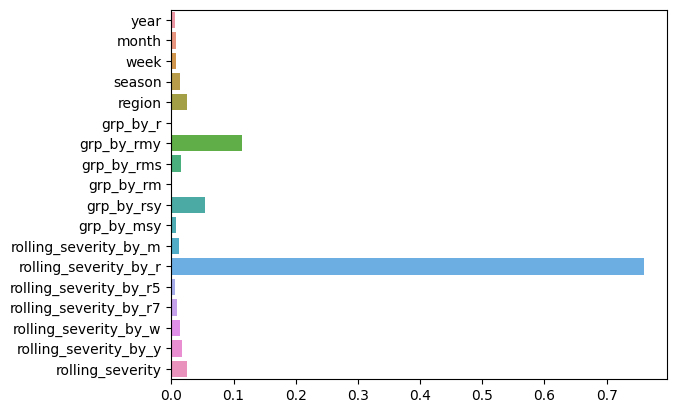

In [186]:
%%time

xgb_reg = XGBRegressor(
    n_estimators=11_000, 
    max_depth=5, 
    learning_rate=0.005, 
    tree_method='gpu_hist',
    gpu_id=0, 
    n_jobs=-1, 
    random_state=42,
    )

te_preds, tr_preds, *_ = cv_it(model=xgb_reg, X_train=X_train, y_train=y_train, X_test=X_val, y_test=y_val, splits=10, cv_predict=True)

In [187]:
data.severity.value_counts(normalize=True)

1.0    0.441367
4.0    0.207402
2.0    0.190719
3.0    0.157029
5.0    0.003482
Name: severity, dtype: float64

In [188]:
# Is the above score realiable?
# - Maynot be due to rolling severities (these can cause the leak to simulate the test set better remove few samples completely from train set before even applying rolling)

In [135]:
%%time

# comparision with 0.66/0.8579
xgb_reg_v0 = XGBRegressor(n_estimators=2000, max_depth=5, learning_rate=0.02, objective='reg:squarederror', tree_method='gpu_hist', gpu_id=0, n_jobs=-1)
xgb_reg_v0.fit(X_train, y_train)
preds = xgb_reg_v0.predict(X_val)
preds = pd.Series(np.round(preds)).clip(1, 5).values
print("train rmse", rmse(y_train, xgb_reg_v0.predict(X_train)))
print("test rmse:", rmse(y_val, preds))

train rmse 0.6388814072911667
test rmse: 0.8064438603416649
CPU times: total: 3.77 s
Wall time: 6.89 s


Using cols:  ['year' 'month' 'week' 'season' 'region' 'grp_by_r' 'grp_by_rmy'
 'grp_by_rms' 'grp_by_rm' 'grp_by_rsy' 'grp_by_msy'
 'rolling_severity_by_m' 'rolling_severity_by_r' 'rolling_severity_by_r5'
 'rolling_severity_by_r7' 'rolling_severity_by_w' 'rolling_severity_by_y'
 'rolling_severity']
----------------------------------Fold-0------------------------------------
Error in making val set more similar to test set
'DataFrame' object has no attribute 'latitude'
Training on 12283 samples
Validating on 1365 samples
1.0    0.441026
4.0    0.207326
2.0    0.187546
3.0    0.160440
5.0    0.003663
Name: severity, dtype: float64
Train RMSE:  0.6791818305635677
Val RMSE: 0.7302967433402214
TEST RMSE:  0.7996922033908588
----------------------------------Fold-1------------------------------------
Error in making val set more similar to test set
'DataFrame' object has no attribute 'latitude'
Training on 12283 samples
Validating on 1365 samples
1.0    0.441026
4.0    0.207326
2.0    0.18754

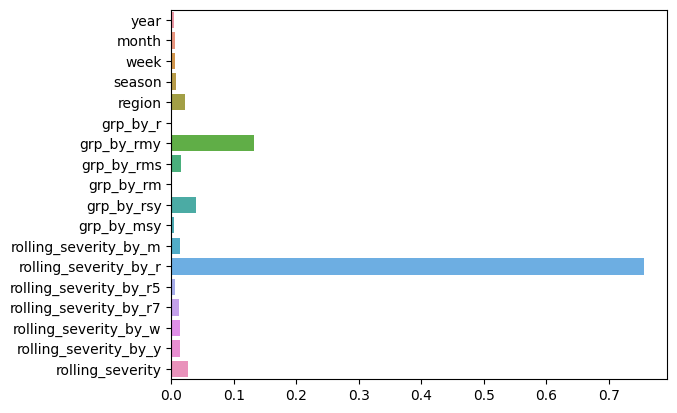

In [136]:
_ = cv_it(model=xgb_reg_v0, X_train=X_train, y_train=y_train, X_test=X_val, y_test=y_val, splits=10, cv_predict=False)

,uid,latitude,longitude,date,split,year,month,week,season,region,...,grp_by_rm,grp_by_rsy,grp_by_msy,rolling_severity_by_m,rolling_severity_by_r,rolling_severity_by_r5,rolling_severity_by_r7,rolling_severity_by_w,rolling_severity_by_y,rolling_severity
0,aabm,39.080319,-86.430867,2018-05-14,train,2018,5,20,2,midwest,...,1.0,1.0,2.0,1.850704,2.0,2.0,2.0,2.277778,1.921779,2.03753
1,aabn,36.559700,-121.510000,2016-08-31,test,2016,8,35,3,west,...,3.0,4.0,2.0,2.000000,4.0,4.0,4.0,1.917526,1.963600,2.03753
2,aacd,35.875083,-78.878434,2020-11-19,train,2020,11,47,4,south,...,2.0,2.0,2.0,1.000000,1.0,2.0,2.0,1.000000,1.000000,1.00000
3,aaee,35.487000,-79.062133,2016-08-24,train,2016,8,34,3,south,...,2.0,2.0,2.0,2.000000,2.0,2.0,2.0,2.133333,1.963600,2.03753
4,aaff,38.049471,-99.827001,2019-07-23,train,2019,7,30,3,midwest,...,2.0,2.0,2.0,2.068316,2.0,2.0,2.0,1.995192,2.200765,2.03753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23565,zzvv,36.708500,-121.749000,2014-12-02,test,2014,12,49,1,west,...,4.0,4.0,3.0,1.782443,4.0,4.0,4.0,2.282353,2.183219,2.03753
23566,zzwo,39.792190,-99.971050,2017-06-19,train,2017,6,25,3,midwest,...,2.0,2.0,2.0,1.925311,2.0,2.0,2.0,2.168182,2.222222,2.03753
23567,zzwq,35.794000,-79.012551,2015-03-24,train,2015,3,13,2,south,...,1.0,1.0,2.0,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.00000
23568,zzyb,35.742000,-79.238600,2016-11-21,train,2016,11,47,4,south,...,2.0,2.0,2.0,2.059233,2.0,2.0,2.0,2.347826,1.963600,2.03753


# Test predictions

In [138]:
X_train.columns

Index(['year', 'month', 'week', 'season', 'region', 'grp_by_r', 'grp_by_rmy',
       'grp_by_rms', 'grp_by_rm', 'grp_by_rsy', 'grp_by_msy',
       'rolling_severity_by_m', 'rolling_severity_by_r',
       'rolling_severity_by_r5', 'rolling_severity_by_r7',
       'rolling_severity_by_w', 'rolling_severity_by_y', 'rolling_severity'],
      dtype='object')

In [154]:

# all_train = all_data[all_data.split == 'train']
# all_test = all_data[all_data.split == 'test']

# add val set to train set
data.loc[val_idx, 'severity'] = val_severity.sort_index()

all_train = data[data.split == 'train']
all_test = data[data.split == 'test']

all_train.region = all_train.region.map(reg_map)
all_test.region = all_test.region.map(reg_map)

all_train.week = all_train.week.astype('int')
all_test.week = all_test.week.astype('int')

drop_cols = drop_cols = ['uid', 'split', 'date', 'severity', 'density', 'latitude', 'longitude', 'mysplit']
all_train.shape, all_test.shape

((17060, 26), (6510, 26))

In [155]:
X = all_train.drop(drop_cols, axis=1)
y = all_train['severity']
X_test = all_test.drop(drop_cols, axis=1)

X.shape, y.shape, X_test.shape

((17060, 18), (17060,), (6510, 18))

In [156]:
assert X_test.columns.equals(X.columns)

In [157]:
print('Training on:', X.columns.values)

xgb_reg = XGBRegressor(
    n_estimators=11_000, 
    max_depth=5, 
    learning_rate=0.005, 
    tree_method='gpu_hist',
    gpu_id=0, 
    n_jobs=-1, 
    random_state=42,
    )

xgb_reg.fit(X, y)
test_preds = xgb_reg.predict(X_test)
test_preds = pd.Series(np.round(test_preds)).clip(1, 5).values
print("train rmse", rmse(y, xgb_reg.predict(X)))

Training on: ['year' 'month' 'week' 'season' 'region' 'grp_by_r' 'grp_by_rmy'
 'grp_by_rms' 'grp_by_rm' 'grp_by_rsy' 'grp_by_msy'
 'rolling_severity_by_m' 'rolling_severity_by_r' 'rolling_severity_by_r5'
 'rolling_severity_by_r7' 'rolling_severity_by_w' 'rolling_severity_by_y'
 'rolling_severity']
train rmse 0.6465779204229488


In [158]:
X.shape, y.shape

((17060, 18), (17060,))

In [159]:
y.value_counts(normalize=True)

1.0    0.439449
4.0    0.207913
2.0    0.189859
3.0    0.159379
5.0    0.003400
Name: severity, dtype: float64

In [160]:
pd.Series(test_preds).value_counts(normalize=True)

2.0    0.374654
4.0    0.290015
1.0    0.181720
3.0    0.153610
dtype: float64

# Submission

In [161]:
sub_format.severity = test_preds.astype(int)
display(sub_format.sample(5))
sub_format.to_csv('../submissions/to submit/xgbreg_rolling3grpby_withoutlatlng.csv', index=False)

,uid,region,severity
2444,jxhi,west,3
5165,uoum,northeast,1
3489,nzpb,west,4
4637,snze,northeast,2
6380,znal,west,4
